# Warping tiles

Most basemap tiles provided through the web are expressed in the Web Mercator coordinate reference system (`EPSG:3857`). However, often our data is not expressed in the same CRS. In those cases, we have two options if we want to plot them on top of a basemap: a) reproject our data to Web Mercator, or b) reproject (warp) the tiles to conform with our data. Which one is best depends on many things but mostly on the size of your own data. If you have a large and/or detailed dataset (e.g. high resolution polygons), reprojecting it might be expensive; if you have a small one, it might be the easiest as you can plot on top of the native tile. For the case where you don't want to transform your dataset, an alternative is to change the tiles to its CRS. In raster parlance, this is called "warping", and `contextily` can help you do that.

In [1]:
%matplotlib inline

import geopandas
import rasterio
from rasterio.plot import show as rioshow
import matplotlib.pyplot as plt
from geodatasets import get_path

import contextily as cx
from contextily.tile import warp_img_transform, warp_tiles, _warper

## Data

For this example, we will use the NYC boroughs dataset provided with `geopandas`:

In [2]:
db = geopandas.read_file(get_path('nybb'))

By default, this dataset is expressed in the "NAD83 / New York Long Island" CRS (`EPSG:2263`):

In [3]:
db.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

## Convert your data to Web Mercator

The first option, if your data is not too large, is to convert them to Web Mercator, and then directly add a basemap (for example, with `add_basemap`):

In [4]:
db_wm = db.to_crs(epsg=3857)

Once projected, the workflow is straightforward:

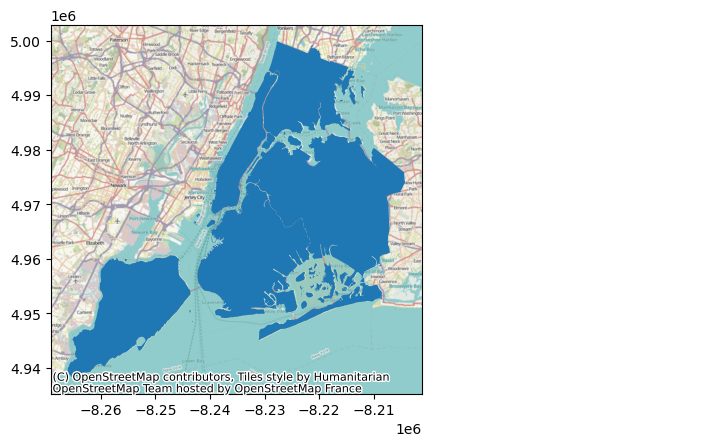

In [5]:
ax = db_wm.plot()
cx.add_basemap(ax);

The result here is a map expressed in Web Mercator.

## Convert the tiles to your data's CRS

The same journey can be travelled in the opposite direction by leaving your data untouched and warping the tiles coming from the web. To do this in `add_basemap`, all you have to do is express the CRS your data are in:

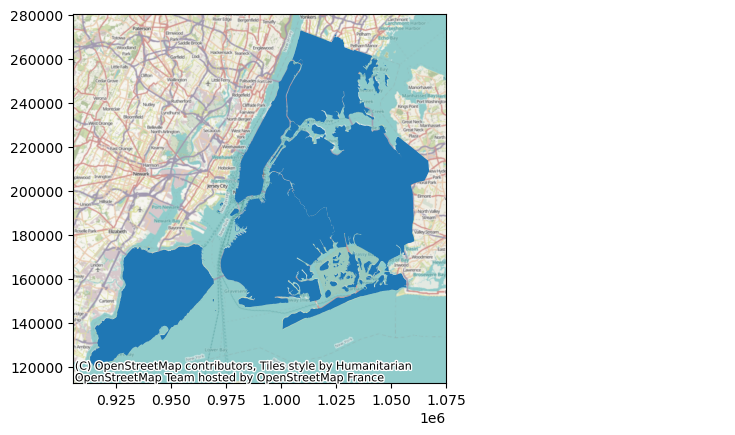

In [6]:
ax = db.plot()
cx.add_basemap(ax, crs=db.crs);

The result is then expressed in NAD83 in this case (note the coordinates of the axes differ across plots). 

## Convert both datasets into a different CRS

It is also possible to make resulting plot in an entirely different CRS. For this, you will need to both project your own data and warp the tiles. For this example, let's use the WGS84 (lon/lat, `EPSG:4326`) CRS for the destination:

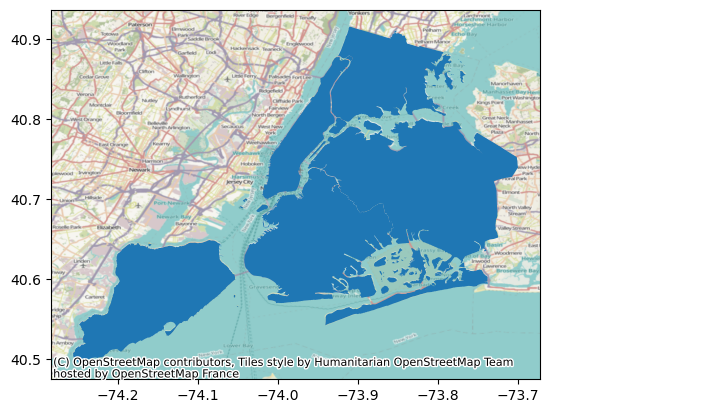

In [7]:
db_lonlat = db.to_crs(epsg=4326)
ax = db_lonlat.plot()
cx.add_basemap(ax, crs=db_lonlat.crs)

Note that the coordinates on the X and Y axis are now expressed in longitude and latitude.

## Warping from local files

The same functionality to warp tiles also works with local rasters stored in disk. This means you can have a a raster saved in one CRS and you can plot it with `add_basemap` on a different CRS. This computation is all done on the fly, so no need to write to intermediate files.

For an example, let's first save a raster with a basemap:

In [8]:
! rm warp_tst.tif

# Extract bounding box in Web Mercator
w, s, e, n = db.to_crs(epsg=3857).total_bounds
# Download file
img, ext = cx.bounds2raster(w, s, e, n, 
                            'warp_tst.tif', 
                            zoom=10
                           )

rm: warp_tst.tif: No such file or directory


The raster we have saved is expressed in Web Mercator:

In [9]:
with rasterio.open("warp_tst.tif", "r") as r:
    print(r.crs)

EPSG:3857


Now we can plot our original data in NAD83 and add a basemap from the (Web Mercator) raster by warping it into NAD83:

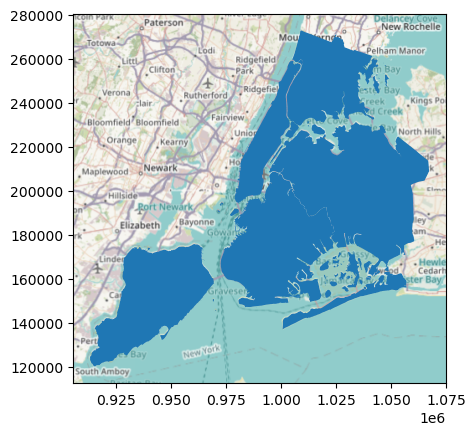

In [10]:
ax = db.plot()
cx.add_basemap(ax, source="warp_tst.tif", crs=db.crs)

## Low-level warping functionality

In most cases, you will probably be fine using `add_basemap`. However, sometimes we need a bit more flexibility and power, even if it takes some more code. For those moments, `contextily` includes two additional functions: `warp_img_transform`, and `warp_tiles`. Let's have a look at each of them!

### `warp_tiles`

This method allows you to warp an image, provided you have its extent and CRS. For example, if you have downloaded an image with `bounds2img`, you can reproject it using `warp_tiles`. Let's download an image from the web:

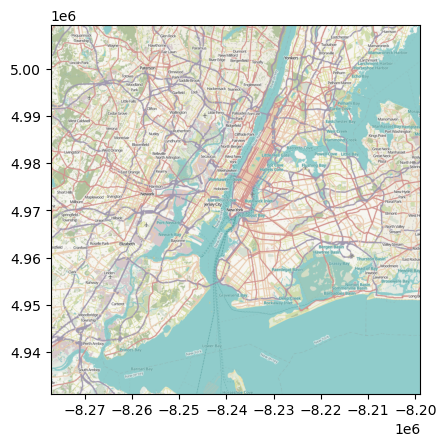

In [11]:
# Extract bounding box in Web Mercator
w, s, e, n = db.to_crs(epsg=3857).total_bounds
# Download image
img, ext = cx.bounds2img(w, s, e, n)
# Render image
plt.imshow(img, extent=ext)

This is expressed in the source CRS, which in this case is Web Mercator. If we want to plot it in say lon/lat, we can warp it by:

In [12]:
warped_img, warped_ext = cx.warp_tiles(img, ext, "EPSG:4326")

And we can render them similarly as before:

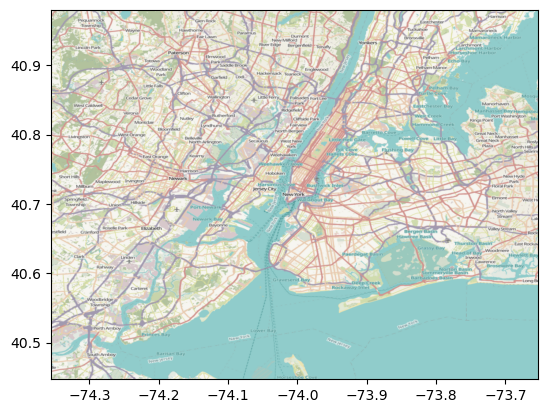

In [13]:
plt.imshow(warped_img, extent=warped_ext)

Note how the extent is now expressed in longitude and latitude.

### `warp_img_transform`

This method allows you to warp an image you have loaded from disk, provided you have its transform and CRS. For example, if you have downloaded an image with `bounds2raster` and stored it in a file, you can read it with `rasterio` and warp it using `warp_img_transform`. Let's use the example from before:

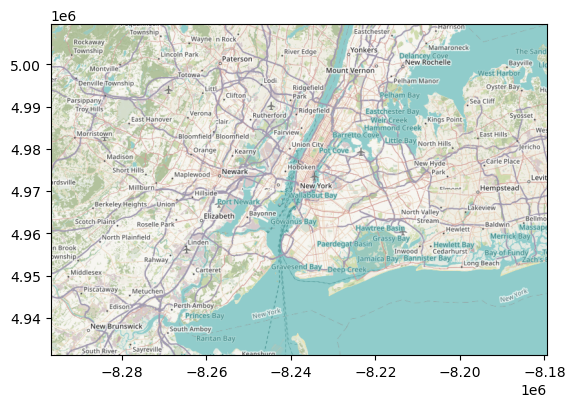

In [14]:
src = rasterio.open('warp_tst.tif')
img = src.read()
rioshow(img, transform=src.transform);

Now to take this into a NAD83, for example, we can:

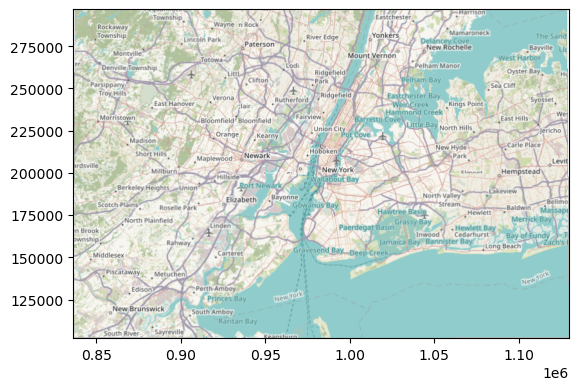

In [15]:
w_img, w_transform = warp_img_transform(img,
                                        src.transform,
                                        src.crs, 
                                        db.crs
                                       )

f, ax = plt.subplots(1)
rioshow(w_img, transform=w_transform, ax=ax);